In [1]:
import requests
import pandas as pd
import time
from datetime import datetime
import json
import matplotlib.pyplot as plt
import os
import re
import numpy as np

In [3]:
market_dict = {
    'binance' :
        ['https://api.binance.com/api/v3/depth', {'symbol' : 'BTCUSDT', 'limit' : 5000}],
    'coinbase' :
        ['https://api.pro.coinbase.com/products/BTC-USD/book', {'level' : 3} ],
    'huobi' : 
        ['https://api.huobi.pro/market/depth', {'symbol' : 'btcusdt', 'type' : 'step1', 'depth': 20}],
    'kraken' : 
        ['https://api.kraken.com/0/public/Depth', {'pair' : 'BTCUSD', 'count' : 50}],
    'bitfinex' : 
        ['https://api-pub.bitfinex.com/v2/book/tBTCUSD/R0/', {'len' : 100}]
    }


In [4]:
while True:
    tic = time.time()
    for name, (url, params) in market_dict.items():
        r = requests.get(url=url, params=params)
        current_time = datetime.now()
        filename = './' + name + '/' + current_time.strftime('%Y-%m-%d_%H:%M:%S')+'.json'
        with open(filename, 'w+') as f:
            f.write(r.text)
    toc = time.time()
    time.sleep(60*5 - (toc - tic))
    break

KeyboardInterrupt: 

I checked

1. HUOBI
2. Coinbase
3. Binance
4. Kraken
5. Bitfinex


In [ ]:
def getRowOfData(asks_df, bids_df, filename):
    """Takes asks and bids, and returns a single row dataframe indexed by time."""
    # Create a new column 'total_amount'
    asks_df['total_amount'] = asks_df['price'] * asks_df['amount']

    
    bids_df['total_amount'] = bids_df['price'] * bids_df['amount']

    # Separates file name from its file extension
    timepoint = os.path.splitext(filename)[0]
    timepoint_datetime = datetime.strptime(timepoint, '%Y-%m-%d_%H_%M_%S')

    ask_twopercent = asks_df['price'] <= asks_df['price'].min() * 1.02
    bid_twopercent = bids_df['price'] >= bids_df['price'].max() * 0.98

    asks_total_two_percent = asks_df[ ask_twopercent ]['total_amount'].sum()
    bids_total_two_percent = bids_df [ bid_twopercent ]['total_amount'].sum()

    asks_average_two_percent = asks_df[ ask_twopercent ]['total_amount'].sum() / asks_df[ask_twopercent]['amount'].sum()
    bids_average_two_percent = bids_df[ bid_twopercent ]['total_amount'].sum() / bids_df[bid_twopercent]['amount'].sum()

    return pd.DataFrame.from_dict({'time' : [timepoint_datetime],
                                        'ask_volume' : [asks_total_two_percent],
                                        'bid_volume' : [bids_total_two_percent],
                                        'ask_avg_price': [asks_average_two_percent],
                                        'bid_avg_price': [bids_average_two_percent],
                                        })

In [209]:
def asks_bids_binance(my_json):
    asks_df = pd.DataFrame(my_json['asks'], columns=['price', 'amount'])
    bids_df = pd.DataFrame(my_json['bids'], columns=['price', 'amount'])
    asks_df = asks_df.astype('float64')
    bids_df = bids_df.astype('float64')
    return asks_df, bids_df

In [215]:
def asks_bids_bitfinex(my_json):
    # Creating two tables (ask_df and bids_df)
    df = pd.DataFrame(my_json, columns = ['scrap', 'price', 'amount'])
    del df['scrap']
    bids_df = df[ df['amount'] > 0]
    asks_df = df[ df['amount'] <= 0].abs()
    asks_df = asks_df.astype('float64')
    bids_df = bids_df.astype('float64')
    
    return asks_df, bids_df

In [216]:
def asks_bids_coinbase(my_json):
    asks_df = pd.DataFrame(my_json['asks'], columns=['price', 'amount', 'scrap'])
    bids_df = pd.DataFrame(my_json['bids'], columns=['price', 'amount', 'scrap'])
    
    del asks_df['scrap']
    del bids_df['scrap']
    
    asks_df = asks_df.astype('float64')
    bids_df = bids_df.astype('float64')
    return asks_df, bids_df

In [212]:
def asks_bids_huobi(my_json):
    asks_df = pd.DataFrame(my_json['tick']['asks'], columns=['price', 'amount'])
    bids_df = pd.DataFrame(my_json['tick']['bids'], columns=['price', 'amount'])
    asks_df = asks_df.astype('float64')
    bids_df = bids_df.astype('float64')
    return asks_df, bids_df

In [217]:
def asks_bids_kraken(my_json):
    asks_df = pd.DataFrame(my_json['result']['XXBTZUSD']['asks'], columns=['price', 'amount', 'scrap'])
    bids_df = pd.DataFrame(my_json['result']['XXBTZUSD']['bids'], columns=['price', 'amount', 'scrap'])
    
    del asks_df['scrap']
    del bids_df['scrap']
    asks_df = asks_df.astype('float64')
    bids_df = bids_df.astype('float64')
    return asks_df, bids_df

In [101]:
#Binance
df_binance_timeline = pd.DataFrame(columns=['time', 'ask_volume', 'bid_volume', 'ask_avg_price', 'bid_avg_price'])

temporary_list = []

for filename in os.listdir('./binance/'):
    with open('./binance/' + filename, 'r') as f:
        my_json = json.load(f)
        # df = pd.DataFrame(my_json, columns = ['order', 'price', 'amount'])
        asks_df, bids_df = asks_bids_binance(my_json)
        df = getRowOfData(asks_df, bids_df, f)
        temporary_list.append(df)

df_binance_timeline = pd.concat(temporary_list)
df_binance_timeline = df_binance_timeline.sort_values(by='time')
df_binance_timeline.to_csv('./data_csvs/binance.csv')

In [95]:
# Bitfinex
df_bitfinex_timeline = pd.DataFrame(columns=['time', 'ask_volume', 'bid_volume'])

# this is for
temporary_list = []

# this is for opening json files
for filename in os.listdir('./bitfinex/'):
    with open('./bitfinex/' + filename, 'r') as f:
        my_json = json.load(f)
        asks_df, bids_df = asks_bids_bitfinex(my_json):
        df = getRowOfData(asks_df, bids_df, f)
        temporary_list.append(df)
        
df_bitfinex_timeline = pd.concat(temporary_list)
df_bitfinex_timeline = df_bitfinex_timeline.sort_values(by='time')
df_bitfinex_timeline.to_csv('./data_csvs/bitfinex.csv')

In [97]:
#Coinbase
df_coinbase_timeline = pd.DataFrame(columns=['time', 'ask_volume', 'bid_volume', 'ask_avg_price', 'bid_avg_price'])

temporary_list = []

for filename in os.listdir('./coinbase/'):
    with open('./coinbase/' + filename, 'r') as f:
        my_json = json.load(f)
        asks_df, bids_df = asks_bids_coinbase(my_json)
        df = getRowOfData(asks_df, bids_df, f)
        temporary_list.append(df)
        
df_coinbase_timeline = pd.concat(temporary_list)
df_coinbase_timeline = df_coinbase_timeline.sort_values(by='time')
df_coinbase_timeline.to_csv('./data_csvs/coinbase.csv')

In [105]:
#HUOBIIII
df_huobi_timeline = pd.DataFrame(columns=['time', 'ask_volume', 'bid_volume', 'ask_avg_price', 'bid_avg_price'])

temporary_list = []

for filename in os.listdir('./huobi/'):
    with open('./huobi/' + filename, 'r') as f:
        my_json = json.load(f)
        asks_df, bids_df = asks_bids_huobi(my_json)
        df = getRowOfData(asks_df, bids_df, f)
        temporary_list.append(df)
        
df_huobi_timeline = pd.concat(temporary_list)
df_huobi_timeline = df_huobi_timeline.sort_values(by='time')
df_huobi_timeline.to_csv('./data_csvs/huobi.csv')

In [99]:
#Kraken
df_kraken_timeline = pd.DataFrame(columns=['time', 'ask_volume', 'bid_volume', 'ask_avg_price', 'bid_avg_price'])

temporary_list = []

for filename in os.listdir('./kraken/'):
    with open('./kraken/' + filename, 'r') as f:
        my_json = json.load(f)
        asks_df, bids_df = asks_bids_kraken(my_json)
        df = getRowOfData(asks_df, bids_df, f)
        temporary_list.append(df)

df_kraken_timeline = pd.concat(temporary_list)
df_kraken_timeline = df_kraken_timeline.sort_values(by='time')
df_kraken_timeline.to_csv('./data_csvs/kraken.csv')

In [90]:
df_coinbase_timeline

,time,ask_volume,bid_volume,ask_avg_price,bid_avg_price
0,2020-08-28 17:01:46,6.326961e+06,3.993815e+06,1182.999689,0.910454
0,2020-08-28 17:06:48,6.442174e+06,3.169169e+06,1201.637823,0.722489
0,2020-08-28 17:11:49,3.466290e+06,4.060124e+06,677.631714,0.925595
0,2020-08-28 17:16:51,4.063863e+06,5.133681e+06,791.155571,1.170306
0,2020-08-28 17:21:53,6.926374e+06,3.682421e+06,1285.289616,0.839493
...,...,...,...,...,...
0,2020-08-30 20:39:07,9.626932e+06,2.910379e+06,1820.170671,0.660552
0,2020-08-30 20:44:07,1.012410e+07,3.106753e+06,1896.220715,0.705111
0,2020-08-30 20:49:07,1.004967e+07,3.474183e+06,1884.640232,0.788507
0,2020-08-30 20:54:07,8.874389e+06,3.313990e+06,1664.635922,0.752152


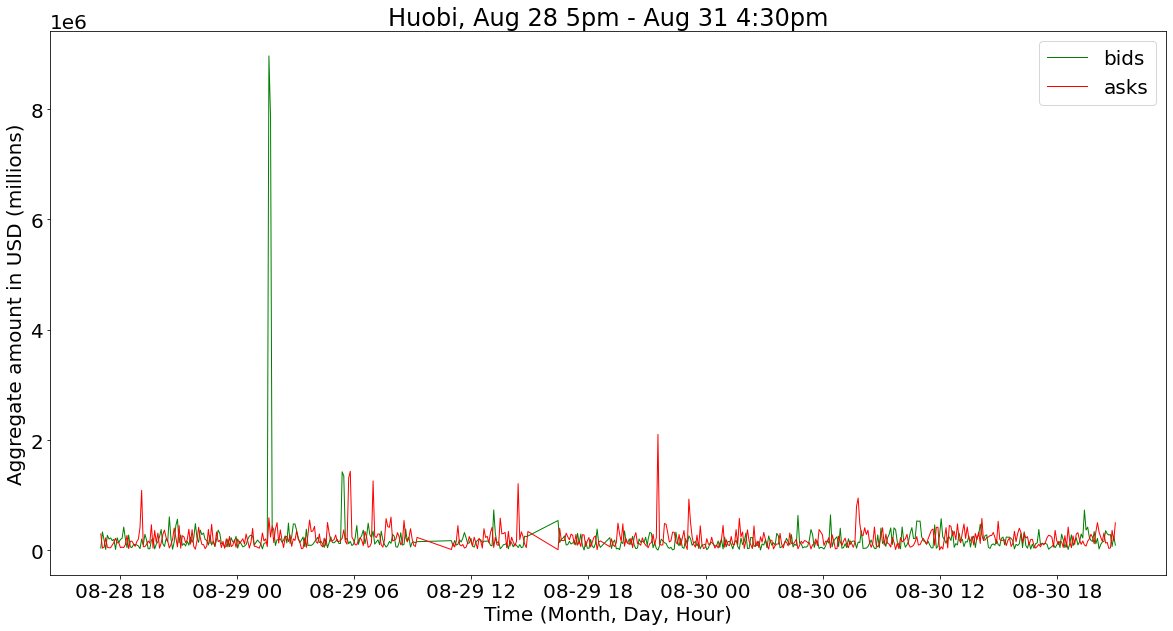

In [109]:
# def my_plot(df, marketname):
for df, name in zip([df_coinbase_timeline, df_binance_timeline, df_huobi_timeline, df_bitfinex_timeline, df_kraken_timeline], 
                    ['Coinbase', 'Binance', 'Huobi', 'Bitfinex', 'Kraken']):

    df = df_huobi_timeline
    marketname = name
    time = df['time']
    bid = df['bid_volume']
    ask = df['ask_volume']
    #bid_avg = df['bid_avg_price']
    #ask_avg = df['ask_avg_price']

    fig= plt.gcf()
    fig.set_size_inches(20,10)

    plt.plot(time, bid, '-g', linewidth=1)
    plt.plot(time, ask, '-r', linewidth=1)
    plt.xlabel('Time (Month, Day, Hour)', fontsize= 20)
    plt.ylabel('Aggregate amount in USD (millions)', fontsize= 20)
    #plt.fill_between(time, bid, color='r', alpha=0.6)
    #plt.fill_between(time, bid, ask, color='g', alpha=0.6)
    # plt.fill_between(time, ask, bid, color='b', alpha=0.6)
    plt.legend(['bids', 'asks'])
    plt.title(str(marketname) + ', Aug 28 5pm - Aug 31 4:30pm')
    plt.rc('font', size=20)
    # plt.yscale('log')

    # plt.show()
    plt.savefig('./figures/' + marketname + '_timeseries.png', dpi=300)

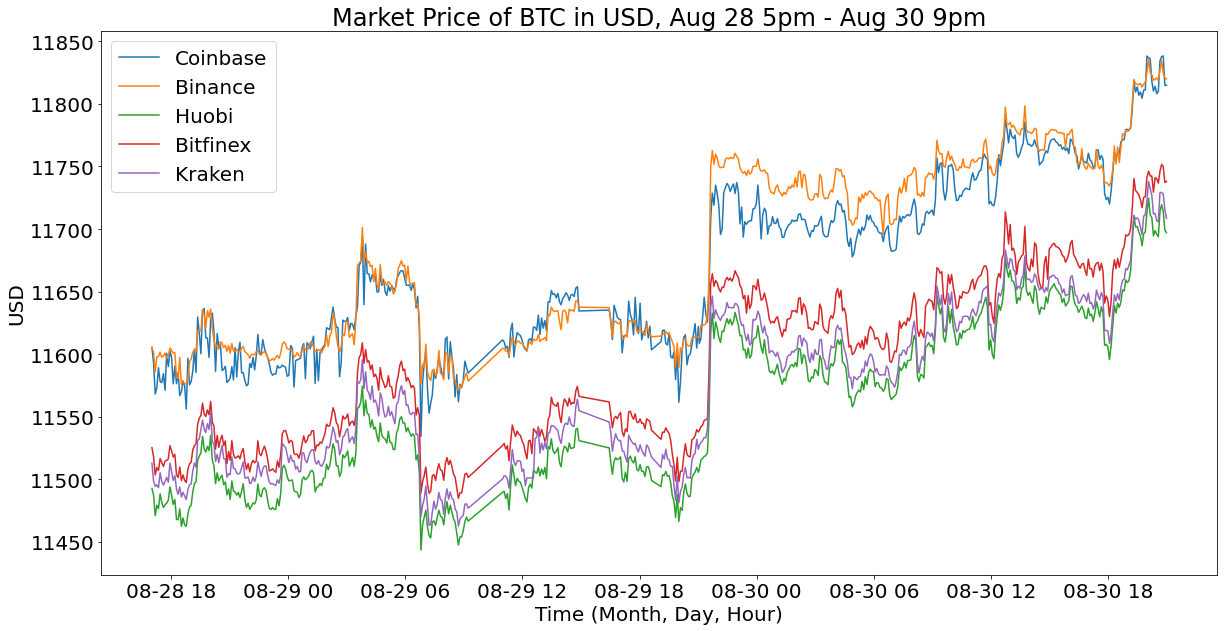

In [438]:
for df in [df_coinbase_timeline, 
                 df_binance_timeline, 
                 df_huobi_timeline, df_bitfinex_timeline, df_kraken_timeline]:
    time = df['time']
    bid_avg = df['bid_avg_price']
    ask_avg = df['ask_avg_price']

    fig = plt.gcf()
    fig.set_size_inches(20,10)
    plt.plot(time, df['ask_avg_price'])
    
plt.xlabel('Time (Month, Day, Hour)', fontsize= 20)
plt.ylabel('USD', fontsize= 20)
plt.legend(['Coinbase', 'Binance', 'Huobi', 'Bitfinex', 'Kraken'])
plt.title('Market Price of BTC in USD, Aug 28 5pm - Aug 30 9pm')
plt.rc('font', size=20)
# plt.show()

plt.savefig('./figures/average_price_timeseries.png', dpi=300)
        

The following is a cost analysis of only utilizing 1 market for a transaction compared to breaking down the order into separate markets 

In [129]:
#Huobi
# purchase = input('Hello, how much Bitco')
for filename in os.listdir('./huobi/'):
    with open('./huobi/2020-08-28_17_01_46.json', 'r') as f:
        json_huobi = json.load(f)
        asks_df = pd.DataFrame(my_json['tick']['asks'], columns=['price', 'amount'])
        bids_df = pd.DataFrame(my_json['tick']['bids'], columns=['price', 'amount'])

In [343]:
df_slippage_timeline = pd.DataFrame(columns=[])

huobi_filenames = [f for f in os.listdir('./huobi')]
kraken_filenames = [f for f in os.listdir('./kraken')]
bitfinex_filenames = [f for f in os.listdir('./bitfinex')]
coinbase_filenames = [f for f in os.listdir('./coinbase')]
binance_filenames = [f for f in os.listdir('./binance')]

temporary_list = []

for f_huo, f_kra, f_bit, f_coi, f_bin in zip(huobi_filenames,
                                             kraken_filenames,
                                             bitfinex_filenames,
                                             coinbase_filenames,
                                             binance_filenames
                                            ):
    with open('./huobi/' + f_huo, 'r') as f:
        my_json = json.load(f)
        asks_df_huobi, bids_df_huobi = asks_bids_huobi(my_json)
    with open('./kraken/' + f_kra, 'r') as f:
        my_json = json.load(f)
        asks_df_kraken, bids_df_kraken = asks_bids_kraken(my_json)
    with open('./bitfinex/' + f_bit, 'r') as f:
        my_json = json.load(f)
        asks_df_bitfinex, bids_df_bitfinex = asks_bids_bitfinex(my_json)
    with open('./coinbase/' + f_coi, 'r') as f:
        my_json = json.load(f)
        asks_df_coinbase, bids_df_coinbase = asks_bids_coinbase(my_json)
    with open('./binance/' + f_bin, 'r') as f:
        my_json = json.load(f)
        asks_df_binance, bids_df_binance = asks_bids_binance(my_json)
        
    asks_df_combined = pd.concat([asks_df_huobi,
                                  asks_df_kraken,
                                  asks_df_bitfinex,
                                  asks_df_coinbase,
                                  asks_df_binance
                                 ])
    bids_df_combined = pd.concat([bids_df_huobi,
                                  bids_df_kraken,
                                  bids_df_bitfinex,
                                  bids_df_coinbase,
                                  bids_df_binance
                                 ])
    
    asks_df_combined = asks_df_combined.sort_values('price')
    bids_df_combined = bids_df_combined.sort_values('price', key=lambda x : -x)
    
    amount = 10
    
    huobi_asks_slippage, huobi_bids_slippage = computeSlippageAt(asks_df_huobi, bids_df_huobi, amount)
    kraken_asks_slippage, kraken_bids_slippage = computeSlippageAt(asks_df_kraken, bids_df_kraken, amount)
    bitfinex_asks_slippage, bitfinex_bids_slippage = computeSlippageAt(asks_df_bitfinex, bids_df_bitfinex, amount)
    coinbase_asks_slippage, coinbase_bids_slippage = computeSlippageAt(asks_df_coinbase, bids_df_coinbase, amount)
    binance_asks_slippage, binance_bids_slippage = computeSlippageAt(asks_df_binance, bids_df_binance, amount)
    combined_asks_slippage, combined_bids_slippage = computeSlippageAt(asks_df_combined, bids_df_combined, amount)
    
    timepoint = os.path.splitext(f_huo)[0]
    timepoint_datetime = datetime.strptime(timepoint, '%Y-%m-%d_%H_%M_%S')

    
    df_slippage_timeline = df_slippage_timeline.append(pd.DataFrame.from_dict({'timepoint' : [timepoint],
#                                                         'huobi asks' : [huobi_asks_slippage],
#                                                         'huobi bids' : [huobi_bids_slippage],
                                                        'kraken asks' : [kraken_asks_slippage],
                                                        'kraken bids' : [kraken_bids_slippage],
                                                        'bitfinex asks' : [bitfinex_asks_slippage],
                                                        'bitfinex bids' : [bitfinex_bids_slippage],
                                                        'coinbase asks' : [coinbase_asks_slippage],
                                                        'coinbase bids' : [coinbase_bids_slippage],
                                                        'binance asks' : [binance_asks_slippage],
                                                        'binance bids' : [binance_bids_slippage],
                                                        'combined asks' : [combined_asks_slippage],
                                                        'combined bids' : [combined_bids_slippage]
                                                       }))

In [344]:
df_slippage_timeline = df_slippage_timeline.sort_values(by='timepoint')
df_slippage_timeline.to_csv('./data_csvs/slippage_10.csv')

In [365]:
slippage_cols_paired = [('kraken asks', 'kraken bids'), ('bitfinex asks',
       'bitfinex bids'), ('coinbase asks', 'coinbase bids'), ('binance asks',
       'binance bids'), ('combined asks', 'combined bids')]

In [439]:
df = df_slippage_timeline
for (asks, bids), name in zip(slippage_cols_paired, ['Kraken', 'Bitfinex', 'Coinbase', 'Binance', 'Combined']):
    marketname = name + ' Asks & Bids Slippage of 10 BTC Orders'
    time = df['timepoint']

    fig= plt.gcf()
    fig.set_size_inches(20,10)
    plt.plot_date(time, df[asks], '--r', linewidth=2, alpha=0.5)
    plt.plot_date(time[6:-5], np.convolve(df[asks],np.ones(12)/12, mode='valid'), '-r', linewidth=4)
    plt.plot_date(time, df[bids], '--g', linewidth=2, alpha=0.5)
    plt.plot_date(time[6:-5], np.convolve(df[bids],np.ones(12)/12, mode='valid'), '-g', linewidth=4)
    
    #     plt.plot(time, ask_avg, '-b', linewidth=2)
    # plt.fill_between(time, bid_avg, color='r', alpha=0.6)
    # plt.fill_between(time, ask_avg, color='b', alpha=0.6)
#         plt.legend(['bid_avg', 'ask_avg'])
    plt.ylim([0,12])
    plt.title(str(marketname) + ', Aug 28 5pm EST - Aug 30 9pm EST')
    plt.rc('font', size=20)

#     plt.show()

    plt.savefig('./figures/Slippage/' + marketname + '_slippage_asks_bids_timeseries.png', dpi=300)
    plt.close()

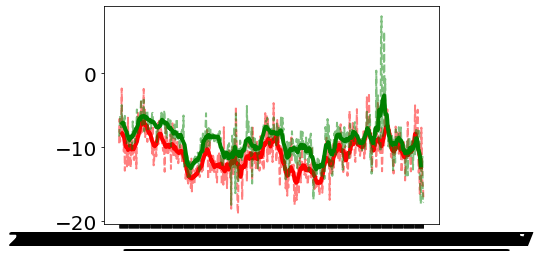

In [370]:
plt.plot(time, df[asks], '--r', linewidth=2, alpha=0.5)
plt.plot(time[6:-5], np.convolve(df[asks],np.ones(12)/12, mode='valid'), '-r', linewidth=4)
plt.plot(time, df[bids], '--g', linewidth=2, alpha=0.5)
plt.plot(time[6:-5], np.convolve(df[bids],np.ones(12)/12, mode='valid'), '-g', linewidth=4)

In [386]:
asks_df = asks_df_combined
bids_df = bids_df_combined

amount = 10

market_price = 0.5 * (asks_df['price'].iat[0] + bids_df['price'].iat[0])
asks_df['amount_cumulative'] = asks_df['amount'].cumsum()
asks_df['total'] = asks_df['amount'] * asks_df['price']
T1_asks = asks_df[asks_df['amount_cumulative'] <= amount]['total'].sum() 
L_asks = len(asks_df[asks_df['amount_cumulative'] <= amount]['amount_cumulative'])
try:
    D_asks = amount - asks_df[asks_df['amount_cumulative'] <= amount]['amount_cumulative'].iat[-1]
except IndexError:
    D_asks = amount
T2_asks = asks_df['price'].iat[L_asks] * D_asks
T_asks = T1_asks + T2_asks
P_asks = T_asks / amount - market_price


In [322]:
def computeSlippageAt(asks_df, bids_df, amount):
    try:
        market_price = 0.5 * (asks_df['price'].iat[0] + bids_df['price'].iat[0])

        asks_df['amount_cumulative'] = asks_df['amount'].cumsum()
        asks_df['total'] = asks_df['amount'] * asks_df['price']
        T1_asks = asks_df[asks_df['amount_cumulative'] <= amount]['total'].sum() 
        L_asks = len(asks_df[asks_df['amount_cumulative'] <= amount]['amount_cumulative'])
        try:
            D_asks = amount - asks_df[asks_df['amount_cumulative'] <= amount]['amount_cumulative'].iat[-1]
        except IndexError:
            D_asks = amount
        T2_asks = asks_df['price'].iat[L_asks] * D_asks
        T_asks = T1_asks + T2_asks
        P_asks = T_asks / amount - market_price

        bids_df['amount_cumulative'] = bids_df['amount'].cumsum()
        bids_df['total'] = bids_df['amount'] * bids_df['price']
        T1_bids = bids_df[bids_df['amount_cumulative'] <= amount]['total'].sum() 
        L_bids = len(bids_df[bids_df['amount_cumulative'] <= amount]['amount_cumulative'])
        try:
            D_bids = amount - bids_df[bids_df['amount_cumulative'] <= amount]['amount_cumulative'].iat[-1]
        except IndexError:
            D_bids = amount
        T2_bids = bids_df['price'].iat[L_bids] * D_bids
        T_bids = T1_bids + T2_bids
        P_bids = market_price - T_bids / amount

        return P_asks, P_bids
    except:
        return np.nan, np.nan

In [430]:
from scipy.stats import linregress

In [433]:
linregress(np.convolve(df_slippage_timeline['binance bids'],np.ones(12)/12), 
           np.convolve(df_binance_timeline['bid_avg_price'], np.ones(12)/12))

LinregressResult(slope=437.64985500038387, intercept=10632.556679253708, rvalue=0.1888365275458204, pvalue=3.647999046932641e-06, stderr=93.61863526116977)